In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # To ignore SettingWithCopyWarning warning

# Import data

In [2]:
path = 'C:/Users/Akis-/OneDrive/Masters/Web Economics/Data/WebEcon Team Drive/Datasets Original/'
#train = pd.read_csv(path+"train.csv")
validation = pd.read_csv(path+"validation.csv")

In [3]:
#print(train.shape, validation.shape)

# Import Predictions

In [4]:
path='C:/Users/Akis-/OneDrive/Masters/Web Economics/Data/WebEcon Team Drive/predictions/'
# lr_preds = pd.read_csv("Prediction_csv/lr_pCTR.csv", index_col  = "Unnamed: 0")
# rf_preds = pd.read_csv("Prediction_csv/rf_pCTR.csv", index_col  = "Unnamed: 0")
####xgb_preds = pd.read_csv("Prediction_csv/xgb_pCTR.csv", index_col  = "Unnamed: 0")
# dwane_preds = pd.read_csv("Prediction_csv/click_predictions_narrow.csv")
# lasso_preds = pd.read_csv("Prediction_csv/lasso_basebid.csv", index_col  = "Unnamed: 0")
# ridge_preds = pd.read_csv("Prediction_csv/ridge_basebid.csv", index_col  = "Unnamed: 0")
# elasticnet_preds = pd.read_csv("Prediction_csv/elasticnet_basebid.csv", index_col  = "Unnamed: 0")
# rfg_preds = pd.read_csv("Prediction_csv/rfg_basebid.csv", index_col  = "Unnamed: 0")
####xgbr_preds = pd.read_csv("Prediction_csv/xgb_basebid.csv", index_col  = "Unnamed: 0")

#xgb_preds = pd.read_csv(path+"xgb_pCTR.csv", index_col  = "Unnamed: 0")
xgb_preds = pd.read_csv(path+"click_predictions_narrow.csv") #, index_col  = "Unnamed: 0
xgbr_preds = pd.read_csv(path+"xgb_basebid.csv", index_col  = "Unnamed: 0")
xgb_preds = xgb_preds.rename(index=str, columns={"pCTR": "click_proba"})

In [5]:
xgb_preds[xgb_preds["click_proba"]>=0.1].head(5)

,bidid,click_proba
10,a74b7ba02a4ccf3571106afb0c800b630a256d9c,0.1
14,0471aa736ae347c30621cb5e193bd12e2635b1f9,1.0
18,db12485ab1e09236b00aa8de2f19cac829711996,1.0
24,f57e7666729b6be498bf870fad347030b8f3518f,0.6
25,92ecd7842dd17411b6565de71d42d068930dd0fc,0.7


In [6]:
print("Predicted Bid Price Min:",xgbr_preds['predicted_payprice'].min())
print("Predicted Bid Price Max:",xgbr_preds['predicted_payprice'].max())
print("Predicted Bid Price Mean:",xgbr_preds['predicted_payprice'].mean())
print("Predicted Bid Price Std:",xgbr_preds['predicted_payprice'].std())

Predicted Bid Price Min: -56.3769416809082
Predicted Bid Price Max: 346.9530944824219
Predicted Bid Price Mean: 78.97979187519267
Predicted Bid Price Std: 36.59964614741366


# Linear Strategy

In [7]:
def Strategy1(sub_pCTR, sub_basebid, C ,BBimportance):
    
    #print(sub_basebid.head(100))
    importance = BBimportance * 10 
    avgCTR = sub_pCTR["click_proba"].mean()
    
    mean = sub_basebid["predicted_payprice"].mean()
    sub_basebid["predicted_payprice"] = sub_basebid["predicted_payprice"]-mean
    sub_basebid["predicted_payprice"] = (importance * sub_basebid["predicted_payprice"]/sub_basebid["predicted_payprice"].max())
    sub_basebid["predicted_payprice"] = sub_basebid["predicted_payprice"] + mean
    #importance is a constant to be played around with
    
    avgBB = sub_basebid["predicted_payprice"].mean()
    
    print("avBB/pBB Min:",(avgBB/sub_basebid["predicted_payprice"]).min())
    print("avBB/pBB Max:",(avgBB/sub_basebid["predicted_payprice"]).max())
#     print("avBB/pBB Mean:",(avgBB/sub_basebid["predicted_payprice"]).mean())
#     print("avBB/pBB Std:",(avgBB/sub_basebid["predicted_payprice"]).std())
#     print()
    
#     print("pCTR/avCTR Min:",(sub_pCTR["click_proba"]/ avgCTR).min())
#     print("pCTR/avCTR Max:",(sub_pCTR["click_proba"]/ avgCTR).max())
#     print("pCTR/avCTR Mean:",(sub_pCTR["click_proba"]/ avgCTR).mean())
#     print("pCTR/avCTR Std:",(sub_pCTR["click_proba"]/ avgCTR).std())
    
    bidprice1 = (avgBB/sub_basebid["predicted_payprice"]) * (sub_pCTR["click_proba"]/ avgCTR) * C
    #print(bidprice1.head(5))
    #sub_pCTR_["click_proba"] = (sub_pCTR_["click_proba"] + (1-avgCTR))**2 - (1-avgCTR)
    #bidprice2 = (avgBB/sub_basebid["predicted_payprice"]) * (sub_pCTR["click_proba"]/ avgCTR) * C
    return bidprice1

In [8]:
def Strategy2(sub_pCTR, sub_basebid, C ,BBimportance):
    
    #print(sub_basebid.head(2))
    importance = BBimportance * 10 
    avgCTR = sub_pCTR["click_proba"].values.mean()
    
    mean = sub_basebid["predicted_payprice"].values.mean()
    sub_basebid["predicted_payprice"] = sub_basebid["predicted_payprice"].values-mean
    sub_basebid["predicted_payprice"] = (importance * sub_basebid["predicted_payprice"].values/sub_basebid["predicted_payprice"].values.max())
    sub_basebid["predicted_payprice"] = sub_basebid["predicted_payprice"].values + mean
    #importance is a constant to be played around with
    
    avgBB = sub_basebid["predicted_payprice"].mean()
    
    print("avBB/pBB Min:",(avgBB/sub_basebid["predicted_payprice"].values).min())
    print("avBB/pBB Max:",(avgBB/sub_basebid["predicted_payprice"].values).max())
#     print("avBB/pBB Mean:",(avgBB/sub_basebid["predicted_payprice"]).mean())
#     print("avBB/pBB Std:",(avgBB/sub_basebid["predicted_payprice"]).std())
#     print()
    
#     print("pCTR/avCTR Min:",(sub_pCTR["click_proba"]/ avgCTR).min())
#     print("pCTR/avCTR Max:",(sub_pCTR["click_proba"]/ avgCTR).max())
#     print("pCTR/avCTR Mean:",(sub_pCTR["click_proba"]/ avgCTR).mean())
#     print("pCTR/avCTR Std:",(sub_pCTR["click_proba"]/ avgCTR).std())
    
    #bidprice1 = (avgBB/sub_basebid["predicted_payprice"]) * (sub_pCTR["click_proba"]/ avgCTR) * C
    sub_pCTR["click_proba"] = (sub_pCTR["click_proba"].values + (1-avgCTR))**2 - (1-avgCTR)
    bidprice2 = (avgBB/sub_basebid["predicted_payprice"].values) * (sub_pCTR["click_proba"].values/ avgCTR) * C
    return bidprice2

In [9]:
#temp1 = Strategy1(xgb_preds, xgbr_preds, 93, 0) # 1 to 15 is a good range

In [10]:
#base_bid = train.loc[ train["click"] == 1, "payprice"].mean()
#base_bid

In [11]:
base_bid = 89
basebids = np.linspace(0.90*base_bid, 1.06*base_bid, 8)
basebids = np.linspace(140, 145, 6)
basebids

array([140., 141., 142., 143., 144., 145.])

# Evaluate Results

In [12]:
budget = 6250*1000

def ValidationDataFrame(submission_pCTR, submission_basebid, C, BBimportance,strategy):
    
    validation_check = validation[["bidid", "click", "bidprice", "payprice"]]
    validation_check["click_proba"] = submission_pCTR["click_proba"]
    validation_check["bidprice_predicted"] = strategy(submission_pCTR, submission_basebid, C , BBimportance)
    #print(validation_check.head(5))
    #print()
    
    return validation_check


def ValidateStrategy(df):
    
    impressions = 0
    clicks = 0
    cost = 0
    auctions_participated = 0
    balance = budget
    
    for row in df.iterrows():
        
        if cost < budget:
            
            auctions_participated+=1
            
            if (row[1]["bidprice_predicted"] >= row[1]["payprice"]):
                
                if (balance > row[1]["bidprice_predicted"]):
                    
                    impressions+=1
                    clicks+=row[1]["click"]
                    cost+=row[1]["payprice"]
                    balance-=row[1]["payprice"]
                else:
                    pass
    
        else:
            break
    
    # Metrics
    ctr = clicks*100/impressions
    cpm = cost/impressions
    cpc = cost/clicks/1000
    
    print("Strategy statistics:")
    print("Auctions participated: {} | Impressions: {} | Clicks: {} | Cost: {} | CTR: {} | CPM: {} | CPC: {}".format(auctions_participated, \
                                                                                                                     impressions, clicks, \
                                                                                                                     cost,\
                                                                                                                     np.round(ctr,5), \
                                                                                                                     np.round(cpm,5), \
                                                                                                                     np.round(cpc,2)))
    print("\n")
            
    return impressions, clicks, cost, auctions_participated, ctr, cpm, cpc

In [13]:
pCTR_model_name = "Multi-Forrest"
results = pd.DataFrame(columns = ["pCTR_model", "Coefficient", "Impressions", "Clicks", "Cost", "CTR", "CPM", "CPC"])
i=0
Strategies=[Strategy2]

start = time.time()

for C in basebids:
    for BBIMPORTANCE in range(0,11,1): #10
        for strat in Strategies:
            print("pCTR model:",pCTR_model_name,"  Constant:",C,"  Strategy:",strat.__name__,"  pBB Importance:",BBIMPORTANCE)
            xgbr_preds_temp = xgbr_preds.copy(True)
            xgb_preds_temp = xgb_preds.copy(True)
            validation_check = ValidationDataFrame(xgb_preds_temp, xgbr_preds_temp, C, BBIMPORTANCE,strat)
            #print(validation_check.head(10))
            impressions, clicks, cost, auctions_participated, ctr, cpm, cpc = ValidateStrategy(validation_check)
            results.loc[i] = [pCTR_model_name, C, impressions, clicks, cost, ctr, cpm, cpc]
            i+=1
    
end = time.time()
print("Total time: {} mins".format((end-start)/60))

pCTR model: Multi-Forrest   Constant: 140.0   Strategy: Strategy2   pBB Importance: 0
avBB/pBB Min: 1.0000000000000004
avBB/pBB Max: 1.0000000000000004
Strategy statistics:
Auctions participated: 303925 | Impressions: 75550 | Clicks: 162 | Cost: 6249958 | CTR: 0.21443 | CPM: 82.72612 | CPC: 38.58


pCTR model: Multi-Forrest   Constant: 140.0   Strategy: Strategy2   pBB Importance: 1
avBB/pBB Min: 0.8876149315562968
avBB/pBB Max: 1.068324344994459
Strategy statistics:
Auctions participated: 303925 | Impressions: 75565 | Clicks: 162 | Cost: 6246850 | CTR: 0.21438 | CPM: 82.66856 | CPC: 38.56


pCTR model: Multi-Forrest   Constant: 140.0   Strategy: Strategy2   pBB Importance: 2
avBB/pBB Min: 0.7979385526975167
avBB/pBB Max: 1.1466698085913871
Strategy statistics:
Auctions participated: 303925 | Impressions: 75525 | Clicks: 162 | Cost: 6237140 | CTR: 0.2145 | CPM: 82.58378 | CPC: 38.5


pCTR model: Multi-Forrest   Constant: 140.0   Strategy: Strategy2   pBB Importance: 3
avBB/pBB Min: 0.7

Strategy statistics:
Auctions participated: 303925 | Impressions: 75604 | Clicks: 162 | Cost: 6226131 | CTR: 0.21427 | CPM: 82.35187 | CPC: 38.43


pCTR model: Multi-Forrest   Constant: 142.0   Strategy: Strategy2   pBB Importance: 6
avBB/pBB Min: 0.5682825597128429
avBB/pBB Max: 1.6226603846390644
Strategy statistics:
Auctions participated: 303925 | Impressions: 75736 | Clicks: 163 | Cost: 6222341 | CTR: 0.21522 | CPM: 82.1583 | CPC: 38.17


pCTR model: Multi-Forrest   Constant: 142.0   Strategy: Strategy2   pBB Importance: 7
avBB/pBB Min: 0.5301376171968193
avBB/pBB Max: 1.8105537318161176
Strategy statistics:
Auctions participated: 303925 | Impressions: 75903 | Clicks: 162 | Cost: 6225075 | CTR: 0.21343 | CPM: 82.01356 | CPC: 38.43


pCTR model: Multi-Forrest   Constant: 142.0   Strategy: Strategy2   pBB Importance: 8
avBB/pBB Min: 0.4967913905510448
avBB/pBB Max: 2.0476591238640167
Strategy statistics:
Auctions participated: 303925 | Impressions: 76031 | Clicks: 162 | Cost: 6226516

Strategy statistics:
Auctions participated: 303925 | Impressions: 75496 | Clicks: 161 | Cost: 6249988 | CTR: 0.21326 | CPM: 82.78568 | CPC: 38.82


pCTR model: Multi-Forrest   Constant: 145.0   Strategy: Strategy2   pBB Importance: 1
avBB/pBB Min: 0.8876149315562968
avBB/pBB Max: 1.068324344994459
Strategy statistics:
Auctions participated: 303925 | Impressions: 75544 | Clicks: 161 | Cost: 6249989 | CTR: 0.21312 | CPM: 82.7331 | CPC: 38.82


pCTR model: Multi-Forrest   Constant: 145.0   Strategy: Strategy2   pBB Importance: 2
avBB/pBB Min: 0.7979385526975167
avBB/pBB Max: 1.1466698085913871
Strategy statistics:
Auctions participated: 303925 | Impressions: 75595 | Clicks: 161 | Cost: 6249968 | CTR: 0.21298 | CPM: 82.677 | CPC: 38.82


pCTR model: Multi-Forrest   Constant: 145.0   Strategy: Strategy2   pBB Importance: 3
avBB/pBB Min: 0.7247196064169675
avBB/pBB Max: 1.2374155602784065
Strategy statistics:
Auctions participated: 303925 | Impressions: 75672 | Clicks: 162 | Cost: 6249906 | 

In [14]:
xgbr_preds.head(10)

,bidid,predicted_payprice
0,bbcb813b6166538503d8b33a5602d7d72f6019dc,50.281219
1,5a07316c49477cb5d9b4d5aa39c27d6c3be7f92d,78.790169
2,f6ece71dae81d6b16bfb24ad6dd5611472d4c673,92.860153
3,b4d5c57c9b38ff5a12954fa01e11931b4e6bfbbb,45.761795
4,0899bf144249458ea9c89188473694bf44c7ca15,64.029907
5,f4c6a9a3b1db6da035c7e2a36d4f5e389095beca,28.720341
6,786a2940f225482dc04d455dc7a7fea436b02e03,100.595055
7,17ada861c6ed0616f88312ba0d3d76c0f95b4940,87.275414
8,6abd8ef3eb678b1afe67dc0cff0aa58413fbf29a,46.565254
9,442ffca310e325abc255e8ff97d9812051336acd,37.040314


In [15]:
xgb_preds.head(10)

,bidid,click_proba
0,bbcb813b6166538503d8b33a5602d7d72f6019dc,0.0
1,5a07316c49477cb5d9b4d5aa39c27d6c3be7f92d,0.0
2,f6ece71dae81d6b16bfb24ad6dd5611472d4c673,0.0
3,b4d5c57c9b38ff5a12954fa01e11931b4e6bfbbb,0.0
4,0899bf144249458ea9c89188473694bf44c7ca15,0.0
5,f4c6a9a3b1db6da035c7e2a36d4f5e389095beca,0.0
6,786a2940f225482dc04d455dc7a7fea436b02e03,0.0
7,17ada861c6ed0616f88312ba0d3d76c0f95b4940,0.0
8,6abd8ef3eb678b1afe67dc0cff0aa58413fbf29a,0.0
9,442ffca310e325abc255e8ff97d9812051336acd,0.0


In [16]:
results.to_csv("ValidationSet_Evaluation_Results_Individual_xgb_xcgr.csv")

In [17]:
results.head()

,pCTR_model,Coefficient,Impressions,Clicks,Cost,CTR,CPM,CPC
0,Multi-Forrest,140.0,75550,162,6249958,0.214428,82.726115,38.579988
1,Multi-Forrest,140.0,75565,162,6246850,0.214385,82.668563,38.560802
2,Multi-Forrest,140.0,75525,162,6237140,0.214499,82.583780,38.500864
3,Multi-Forrest,140.0,75472,162,6226276,0.214649,82.497827,38.433802
4,Multi-Forrest,140.0,75432,162,6216709,0.214763,82.414744,38.374747


In [18]:
results.sort_values(by = ["Clicks",'CTR'], ascending = False)

,pCTR_model,Coefficient,Impressions,Clicks,Cost,CTR,CPM,CPC
28,Multi-Forrest,142.0,75736,163,6222341,0.215221,82.158300,38.173871
39,Multi-Forrest,143.0,75893,163,6233206,0.214776,82.131501,38.240528
60,Multi-Forrest,145.0,75985,163,6249957,0.214516,82.252510,38.343294
40,Multi-Forrest,143.0,76037,163,6234270,0.214369,81.989952,38.247055
50,Multi-Forrest,144.0,76060,163,6245339,0.214304,82.110689,38.314963
61,Multi-Forrest,145.0,76137,163,6249934,0.214088,82.087999,38.343153
51,Multi-Forrest,144.0,76157,163,6242171,0.214032,81.964508,38.295528
52,Multi-Forrest,144.0,76237,163,6242650,0.213807,81.884780,38.298466
62,Multi-Forrest,145.0,76260,163,6249623,0.213742,81.951521,38.341245
63,Multi-Forrest,145.0,76314,163,6249050,0.213591,81.886024,38.337730


ValueError: x and y must have same first dimension, but have shapes (6,) and (66,)

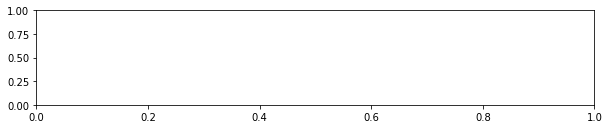

In [19]:
plt.figure(figsize = (10,8))

plt.subplot(4,1,1)
plt.plot(basebids, results["Clicks"])
plt.ylabel("Clicks")

plt.subplot(4,1,2)
plt.plot(basebids, results["Impressions"])
plt.ylabel("Impressions")

plt.subplot(4,1,3)
plt.plot(basebids, results["CTR"])
plt.ylabel("CTR")

plt.subplot(4,1,4)
plt.plot(basebids, results["Cost"])
plt.ylabel("Cost")
plt.xlabel("Constant")

plt.tight_layout()